# Introduction

In this project, we aim to prodive some data-driven insights for Tork, Essity. We build a model to classify if there are sufficient dispensors for every locations and also build a model to predict the number of dispensors needed for potential clients in the future.

The business value of Tork EasyCube consists of main 4 dimensions: fewer cleaning rounds, fewer cleaning hours, higher customer satisfaction rate, and well replenished washrooms. It is of importance to further promote and develop the core business values. We aim to accomplish the mutual benefit by utilizing the data to analyze the **dispensors' optimal allocation** for our clients. By optimazing the dispensers' allocation, Tork's clients will be able to reduce the waste in labor and utilize the resources and refillment, which will create a healthy environment especially during Covid pandemic, and make a more efficient use of cleaning staff. Thus, Tork will be able to better achieve their core business value of Tork EasyTube, to sell more hygience products, and to increase the Tork EasyTube subscriptions rate.

Throughout this process, we did data cleaning, exploratory data analysis, feature engineering, and modeling. 

# Table of Content

# Import Data
* [Import Data](#S1)
* [Exploratory Data Analysis](#S2)
  * [Highlight 1: Find 'location' Density via Node Path](#S2.1)
  * [Highlight 2: Find Average Number of PeopleCounter per Location](#S2.2)
 * [Highlight 3: Find Hourly Visitor Count](#S2.3)
 * [Highlight 4: Outlier Detection: Abnormally High Traffic](#2.4)
 * [Highlight 5: Visitor Count Distribution by Day and Hours](#2.5)
 * [Highlight 6: Dispenser per Location](#2.6)
 * [Highlight 7: Dispenser per Visit Ratio](#2.7)
    * [Outlier Detection: Find Locations with Insufficient Dispensers via Number of Visitors](#2.7.1)
 * [Highlight 8: Find Dispensers' Refillment Interval](#2.8)
    * [Data Integrity: Duplicated Signals](#2.8.1)
    * [Outlier Detection: Find Locations with Insufficient Dispenrs via Refillment Interval](#2.8.2)
 * [Highlight 9: Impact of Product Quality on Refillment Frequency](#2.9)
* [Modeling](#S3)
  * [Prepare Data](#S3.1)
  * [Regression](#3.2)
      * [Model Tuning](#3.2.1)
      * [Results and Interpretations](#3.2.2)
  * [Classification](#3.3)
      * [Results and Interpretations](3.3.1)
* [Limitation](#S6)
* [Conclusions](#S4) 
* [Next Steps](#S5)

In [ ]:
!pip install pandasql
!pip install category_encoders

In [ ]:
# Data Processing
import pandas as pd
import numpy as np
import pandasql as ps
from scipy import stats

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
PALETTE = "rainbow"

# Modeling
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

# Import Data <a class="anchor" id="S1"></a>

Data are stored in 11 .csv files. Downloaded directly from Google drive, stored as pandas dataframes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = r"/content/gdrive/Shareddrives/datathon/Data/"

!ls $data_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
dispensers.csv	   planlocations.csv	 scu_log.csv		 users.csv
finishedtasks.csv  plans.csv		 sitedefaultrefills.csv  vru_log.csv
locations.csv	   refillassortment.csv  sites.csv


In [ ]:
sites = pd.read_csv(data_dir+"sites.csv", error_bad_lines=False,sep = ';')
users = pd.read_csv(data_dir+"users.csv", error_bad_lines=False,sep = ';')
vru_log = pd.read_csv(data_dir+"vru_log.csv", error_bad_lines=False,sep = ';')
sitedefaultrefills = pd.read_csv(data_dir+"sitedefaultrefills.csv", error_bad_lines=False,sep = ';')
refillassotment = pd.read_csv(data_dir+"refillassortment.csv", error_bad_lines=False,sep = ';')
plans = pd.read_csv(data_dir+"plans.csv", error_bad_lines=False,sep = ';')
planlocations = pd.read_csv(data_dir+"planlocations.csv", error_bad_lines=False,sep = ';')
locations = pd.read_csv(data_dir+"locations.csv", error_bad_lines=False,sep = ';')
finishedtasks = pd.read_csv(data_dir+"finishedtasks.csv", error_bad_lines=False,sep = ';')
dispensers = pd.read_csv(data_dir+"dispensers.csv", error_bad_lines=False,sep = ';')
scu_log = pd.read_csv(data_dir+"scu_log.csv", engine='python', error_bad_lines=False,sep = ';')

Skipping line 2363815: unexpected end of data


# Exploratory Data Analysis <a class="anchor" id="S2"></a>

Our inital approach of the data would be exploratory data analysis. As we going through each table finding its specific features and parameters to understand the composition of the data. \\
In this process we will finding empty rate in those tables and doing imputation and cleaning to pre-process data for model training. 

We started our analysis with the *sites* table.

In [ ]:
sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerId                      15 non-null     int64  
 1   CustomerName                    15 non-null     object 
 2   SiteId                          15 non-null     int64  
 3   SiteName                        15 non-null     object 
 4   CountryCode                     15 non-null     object 
 5   TimezoneId                      15 non-null     object 
 6   CreatedAt                       15 non-null     object 
 7   UpdatedAt                       15 non-null     object 
 8   SubscriptionName                15 non-null     object 
 9   SubscriptionRate                15 non-null     int64  
 10  SubscriptionStart               15 non-null     object 
 11  SubscriptionEnd                 0 non-null      float64
 12  SubscriptionIsActive            15 non

In [ ]:
sites.groupby(by = "CustomerName").SiteId.count()

CustomerName
Customer 1266    1
Customer 1291    2
Customer 1326    1
Customer 133     1
Customer 148     1
Customer 163     1
Customer 166     1
Customer 179     1
Customer 23      1
Customer 28      1
Customer 32      1
Customer 77      1
Customer 9       1
Customer 91      1
Name: SiteId, dtype: int64

*Sites* contain 15 sites, 14 distinct customers, with Customer1291 owning 2 sites.

CustomerName
Customer 166      199
Customer 23       392
Customer 28       439
Customer 148      739
Customer 77      3278
Customer 32      4006
Customer 1291    4071
Customer 1266    5473
Customer 1326    5782
Customer 9       7492
Customer 133     8035
Customer 179     8530
Customer 91      8916
Customer 163     9948
Name: SubscriptionRate, dtype: int64


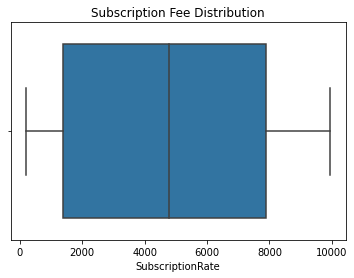

In [ ]:
print(sites.groupby(by = "CustomerName").SubscriptionRate.sum().sort_values())

sns.boxplot(sites.groupby(by = "CustomerName").SubscriptionRate.sum())
plt.title("Subscription Fee Distribution")
plt.show()

Subscription Rate ranges from 199 to 9948, with a gap between 739 and 3278. 

Moving forward to the *locations* table, referencing the *sites* table by *SiteId*.

In [ ]:
# Find percentages of missing values by feature
locations.isna().sum()/len(locations.index)

LocationId                    0.000000
LocationName                  0.000000
SiteId                        0.000000
NodeLevel                     0.000000
NodePath                      0.000000
ParentNodePath                0.000000
LowUrgencyThreshold           0.804972
HighUrgencyThreshold          0.804972
PeopleCounterId               0.635854
PeopleCounterIsProvisioned    0.635854
PeopleCounterCreatedAt        0.635854
dtype: float64

Column **LowUrgencyThreshold**, **HighUrgencyThreshold**, **PeopleCoutnerId**, **PeopleCounterIsProvisioned**, **PeopleCounterCreatedAt** have more than 60% data missing.



In [ ]:
print("Total present people counter {}".format(locations.PeopleCounterId.count()))
print("Total supervised present people counter {}".format(locations.PeopleCounterIsProvisioned.sum()))

Total present people counter 1040
Total supervised present people counter 1040


**PeopleCounterId** and **PeopleCounterIsProvisioned** contain duplicated information, both suggesting if a counter is present.

Join *sites* and *locations* using **SiteId**. 

In [ ]:
join_sit_loc_query = """
  SELECT *
  FROM locations L LEFT JOIN sites S ON S.SiteId=L.SiteId 
"""

site_loc = ps.sqldf(join_sit_loc_query, locals())
site_loc.head(3)

,LocationId,LocationName,SiteId,NodeLevel,NodePath,ParentNodePath,LowUrgencyThreshold,HighUrgencyThreshold,PeopleCounterId,PeopleCounterIsProvisioned,PeopleCounterCreatedAt,CustomerId,CustomerName,SiteId,SiteName,CountryCode,TimezoneId,CreatedAt,UpdatedAt,SubscriptionName,SubscriptionRate,SubscriptionStart,SubscriptionEnd,SubscriptionIsActive,SubscriptionProductCode,SubscriptionProductName,SubscriptionProductDescription
0,162171,Site 9,9,1,/9/,/,NaN,NaN,NaN,NaN,None,9,Customer 9,9,Site 9,de,W. Europe Standard Time,2015-11-19 18:21:07.3000000 +00:00,2017-12-15 13:13:46.9766667 +00:00,Subscription 9,7492,2015-11-19 18:21:07.3000000 +00:00,None,1,P001,DCP 500,Digital Cleaning Plans 500
1,1157,Location 1157,9,2,/9/1/,/9/,NaN,NaN,NaN,NaN,None,9,Customer 9,9,Site 9,de,W. Europe Standard Time,2015-11-19 18:21:07.3000000 +00:00,2017-12-15 13:13:46.9766667 +00:00,Subscription 9,7492,2015-11-19 18:21:07.3000000 +00:00,None,1,P001,DCP 500,Digital Cleaning Plans 500
2,1158,Location 1158,9,3,/9/1/1/,/9/1/,NaN,NaN,NaN,NaN,None,9,Customer 9,9,Site 9,de,W. Europe Standard Time,2015-11-19 18:21:07.3000000 +00:00,2017-12-15 13:13:46.9766667 +00:00,Subscription 9,7492,2015-11-19 18:21:07.3000000 +00:00,None,1,P001,DCP 500,Digital Cleaning Plans 500


### Highlight 1: Find 'location' Density via Node Path <a class="anchor" id="S2.1"></a>

To understand the geographical lay out of locations (in terms of branch from parent node), we grouped data by **ParentNodePath** and counted how many child locations does a parent node own.

count    2856.000000
mean       11.613445
std        11.664655
min         1.000000
25%         4.000000
50%         7.000000
75%        15.000000
max        60.000000
Name: locationDensity, dtype: float64


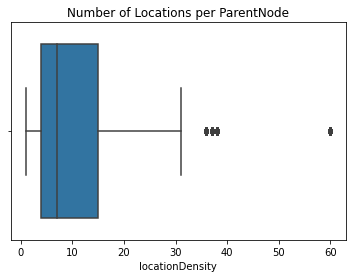

In [ ]:
 site_loc['locationDensity'] = site_loc['LocationId'].groupby(site_loc['ParentNodePath']).transform('count')

 sns.boxplot(site_loc.locationDensity)
 plt.title('Number of Locations per ParentNode')

print(site_loc.describe()['locationDensity'])

Statistics above suggest a wide range of number of child locations per parent node, from 1 to as many as 60. A large number of child nodes implies an spacious area. This newly created feature thus can be used as a general summary of the spatial property that each loation belongs to.

---

  CountryCode  LocationCounts
2          dk              70
7          uk             109
6          sg             134
1          de             214
0          ch             278
3          nl             358
4          no             634
5          se            1054


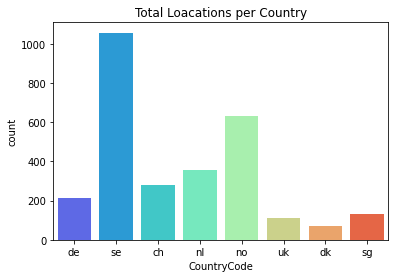

In [ ]:
# Locations grouped by country
print(site_loc.groupby(by=['CountryCode']).LocationId.nunique().reset_index(name='LocationCounts').sort_values(['LocationCounts']))

sns.countplot(x='CountryCode', data=site_loc, palette=PALETTE)
plt.title('Total Loacations per Country')
plt.show()

From the graph above we could see that most of the sites of customers of Tork are from North European Countries. Several other sites are from within Europe and Sigapore.

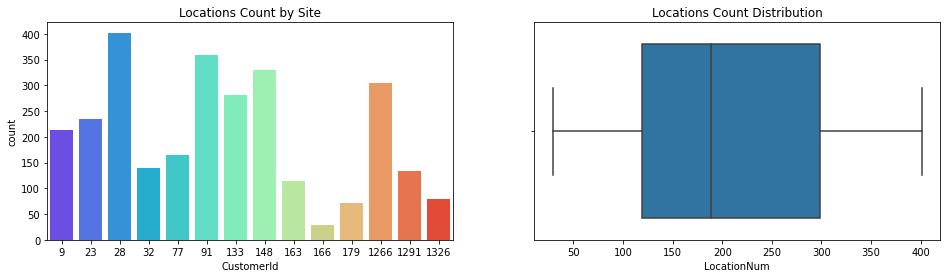

    CustomerId  LocationNum
9          166           29
10         179           70
13        1326           80
8          163          114
12        1291          134
3           32          139
4           77          164
0            9          214
1           23          235
6          133          279
11        1266          305
7          148          329
5           91          358
2           28          401


In [ ]:
location_count=site_loc.groupby(by=['CustomerId']).agg({"LocationId" : pd.Series.nunique }).reset_index().rename(columns= {"LocationId": "LocationNum"}).sort_values("LocationNum")

_, axes = plt.subplots(1,2, figsize=(16,4))
sns.countplot(x='CustomerId', data=site_loc, palette=PALETTE, ax=axes[0])
axes[0].title.set_text("Locations Count by Site")

sns.boxplot(location_count.LocationNum, ax=axes[1])
axes[1].title.set_text("Locations Count Distribution")
plt.show()

print(location_count)

Customer28 has the maximum number of locations that are equipped with Tork's products. The number of locations per client is wide (29 to 401), with quantiles 114, 164, 305.

## Highlight 2: Find Average Number of PeopleCounter per Location <a class="anchor" id="S2.2"></a>

In [ ]:
# Find number of people counter per location
counter_count = site_loc.groupby('SiteName').PeopleCounterId.count().to_frame()
location_count=site_loc.groupby('SiteName').agg({"LocationId" : pd.Series.nunique }).reset_index().rename(columns= {"LocationId": "LocationNum"})
counter_loc = counter_count.merge(location_count, on='SiteName')

# Find percentages of locations equipped with PeopleCounter per site
counter_loc['CounterRatio']=counter_loc['PeopleCounterId']/counter_loc['LocationNum']
print(counter_loc[['SiteName','CounterRatio']].sort_values('CounterRatio'))


     SiteName  CounterRatio
7   Site 2284      0.144262
12    Site 28      0.169576
2    Site 165      0.186380
6    Site 200      0.214286
0    Site 111      0.219512
3    Site 176      0.249240
8     Site 23      0.336170
1    Site 131      0.502793
5    Site 192      0.517241
13    Site 32      0.568345
4    Site 190      0.631579
9   Site 2310      0.704545
10  Site 2344      0.712500
11  Site 2388      0.744444
14     Site 9      0.761682


A **CounterRatio** equal to 1 implies on average, 1 location has 1 people flow count sensor. Unfortunately, all sites provided has a **CounterRatio** below 1, limiting the size of available traffic data. 

---

As we proceed with analyzing traffic per location, we should be aware that this data may not be representative of all sites, as much traffic data was not collected.

In [ ]:
vru_log.head(3)

,intcnt,id,vru_id,manufacture_year,timestamp,counter_in,counter_out,batterylevel,signal_quality,signal_strength,software_version,dcu_id,dcu_version,count_in_from_sensor,count_out_from_sensor,status,PeopleCounterId
0,1,140241981,286,20,2019-01-01 04:00:00.0000000,26664,0,3260,255,78,42,104,6,26664,0,0.0,2000.0
1,1,140253001,286,20,2019-01-01 05:00:00.0000000,26666,0,3260,255,74,42,104,6,26666,0,0.0,2000.0
2,1,140264383,286,20,2019-01-01 07:00:00.0000000,26668,0,3260,255,77,42,104,6,26668,0,0.0,2000.0


In [ ]:
# Find percentages of missing values per column
vru_log.isna().sum()/len(vru_log.index)

intcnt                   0.000000
id                       0.000000
vru_id                   0.000000
manufacture_year         0.000000
timestamp                0.000000
counter_in               0.000000
counter_out              0.000000
batterylevel             0.000000
signal_quality           0.000000
signal_strength          0.000000
software_version         0.000000
dcu_id                   0.000000
dcu_version              0.000000
count_in_from_sensor     0.000000
count_out_from_sensor    0.000000
status                   0.000006
PeopleCounterId          0.000006
dtype: float64

Only 1 entry has **stauts** and **PeopleCounterId** missing. 

In [ ]:
vru_log.manufacture_year.value_counts()

20    157785
Name: manufacture_year, dtype: int64

All sensors withi this table are manufactured in the year of 20.

In [ ]:
vru_log.counter_out.value_counts()

0    157785
Name: counter_out, dtype: int64

In [ ]:
vru_log.count_out_from_sensor.value_counts()

0    157785
Name: count_out_from_sensor, dtype: int64

Both **counter_out** and **count_out_from_sensor** have only 0 entries. 

In [ ]:
vru_log[['counter_in','count_in_from_sensor']].describe()

,counter_in,count_in_from_sensor
count,1.577850e+05,1.577850e+05
mean,3.447766e+05,3.447766e+05
std,2.774241e+05,2.774241e+05
min,1.158000e+04,1.158000e+04
25%,1.606590e+05,1.606590e+05
50%,2.636640e+05,2.636640e+05
75%,4.086050e+05,4.086050e+05
max,1.519255e+06,1.519255e+06


Both **counter_in** and **count_in_from_sensor** record the count from the sensor as seen in the gateway, one column can be safely dropped.	

In [ ]:
vru_log[['vru_id','PeopleCounterId']].nunique() # Both vru_id and PeopleCounterId uniquely identify a senser

vru_id             102
PeopleCounterId    102
dtype: int64

Based on observations above, to save computation and storage cost, we will be dropping following features from *vru_log*:

* intcnt - used to filter data
* manufacture_year - all sensors are manufactured in the year of 20
* counter_out, count_out_from_sensor - only have 0 entry
* id - uniquely identify an entry of a table
* count_in_from_sensor - same as **counter_in**
* vru_id - same as **PeopleCounterId**

In [ ]:
# For prospective join operations, use PeopleCounterId to uniquely identify sensors
vru_log.vru_id = vru_log.PeopleCounterId

vru_log.drop(labels=['intcnt','counter_out','count_out_from_sensor','id','count_in_from_sensor', 'manufacture_year','PeopleCounterId'], axis='columns', inplace=True)

From given data, we observe that **timestamp** is recorded in hour, **counter_in** stores the cumulative count. Our next step is to find the hourly, daily number of visits per location.

**Note**: For the subsequent analysis on *vru_log*, we will be assuming the sensors do not suffer malfunctions, and thus the data accurately record visitor counts.

## Highlight 3: Find Hourly Visitor Count <a class="anchor" id="S2.3"></a>

In [ ]:
# Convert data to type timestamp
vru_log['timestamp'] = pd.to_datetime(vru_log.timestamp)

# Extract weekday, month, date, hour
vru_log['weekday'] = vru_log.timestamp.dt.dayofweek
vru_log['month'] = vru_log.timestamp.dt.month
vru_log['TimeofDay'] = vru_log.timestamp.dt.hour
vru_log['date'] = vru_log.timestamp.dt.date

In [ ]:
# Calculate hourly entrances
vru_log.sort_values(['vru_id','timestamp'], inplace=True)
vru_log['hourly_entry_count'] = vru_log.counter_in.diff()/2.0 # Divide 2 each visitor activates sensor twice (in and out)

# Adjust boundaries
mask = vru_log.vru_id != vru_log.vru_id.shift(1)
vru_log['hourly_entry_count'][mask] = np.nan

Text(0.5, 1.0, 'Distribution of Visitor Count by Hour')

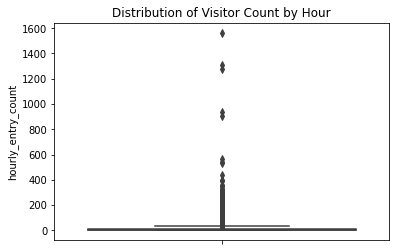

In [ ]:
sns.boxplot(y="hourly_entry_count", data=vru_log)
plt.title("Distribution of Visitor Count by Hour")

Notice that certain sensor in specific hours may experience abnormally high traffic, which may trigger **high demand for dispensers** and would require higher frequency of refill request to cleaning staff.

Text(0.5, 1.0, 'Distribution of Visitor Count by Hour')

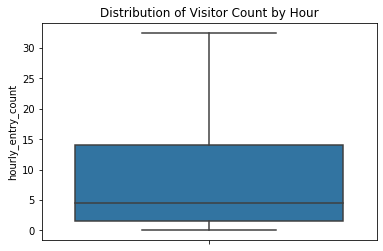

In [ ]:
sns.boxplot(y="hourly_entry_count", data=vru_log, showfliers=False)
plt.title("Distribution of Visitor Count by Hour")

After removing the outliers, above graph suggests the distribution of visitor by hour, with quantiles around 3, 5, 15.

We would like to find at what hours restrooms are more likely to experience unusually high traffic by filtering entries with **hourly_entry_cout** above the 90 percentile.

---


## Highlight 4: Abnormally High Traffic, Outlier Detection <a class="anchor" id="S2.4"></a>

In this detection, we only keep traffic counter data that has outlier that are higher than 90 quantile of the whole traffic count.

In [ ]:
# Find locations with high traffic
q = vru_log.hourly_entry_count.quantile(0.9)
high_hourly_entry = vru_log[vru_log['hourly_entry_count']>=q]

    TimeofDay  count
17         18   1925
16         17   1889
15         16   1807
13         14   1717
14         15   1659
12         13   1592
11         12   1388
18         19   1178
10         11    874
19         20    824
9          10    412
20         21    239
8           9    168
7           8     42
21         22     23
22         23     11
0           1      9
6           7      7
5           6      6
2           3      3
1           2      2
4           5      2
3           4      1


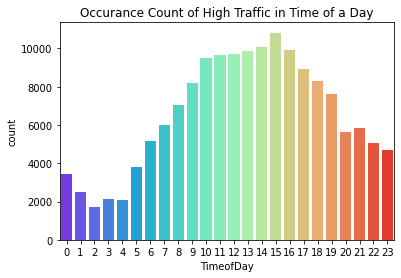

In [ ]:
print(high_hourly_entry.groupby(['TimeofDay']).vru_id.count().reset_index(name='count').sort_values(['count'], ascending=False))

sns.countplot(x=vru_log.TimeofDay,palette=PALETTE)
plt.title('Occurance Count of High Traffic in Time of a Day')
plt.show()

As the table and visual above suggest, restrooms are more likely to experience abnormally high traffic at 15:00-17:00.

---

## Highlight 5: Visitor Count Distribution by Day and Hour <a class="anchor" id="S2.5"></a>

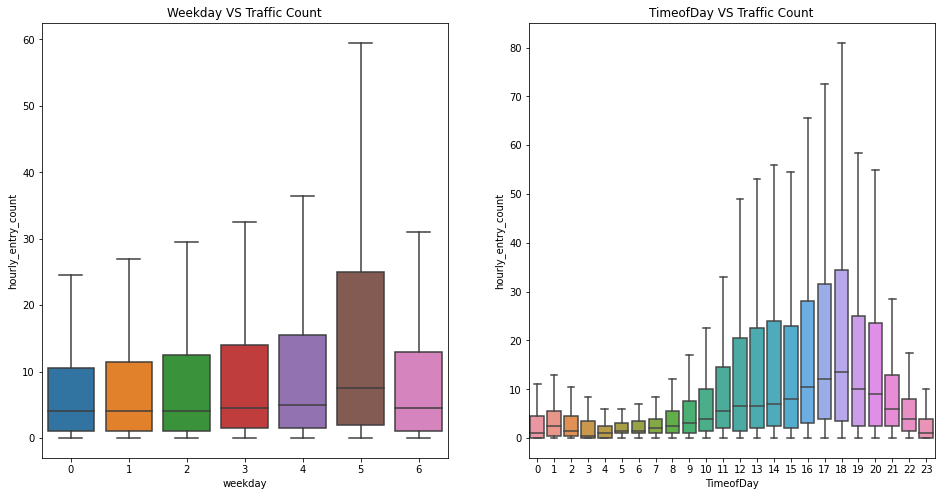

In [ ]:
# Back to total hourly_entry_count
fig,axes = plt.subplots(1,2,figsize=(16,8))

sns.boxplot(x=vru_log.weekday,y=vru_log.hourly_entry_count, showfliers=False, ax=axes[0])
axes[0].title.set_text("Weekday VS Traffic Count")

sns.boxplot(x=vru_log.TimeofDay,y=vru_log.hourly_entry_count, showfliers=False, ax=axes[1])
axes[1].title.set_text("TimeofDay VS Traffic Count")

Back to total number of visitors per location, visuals above suggest Fridays experience highest traffic. Unlike 'abnormally high usage' analyzed in the previous step(15:00-17:00), in regular days , restrooms meet largest number of visits in 16:00-18:00. \\

Subsequently, we will be analyzing the daily total visits per restroom.

In [ ]:
# Find the difference between first and last counter_in each day for each sensor
def get_first_last_entrance(df):
  return df.iloc[-1]['counter_in']-df.iloc[0]['counter_in']

daily_count = vru_log.groupby(['vru_id','date']).apply(get_first_last_entrance).rename("daily_count")

In [ ]:
daily_count = daily_count.reset_index()
daily_count

,vru_id,date,daily_count
0,1930.0,2019-01-01,61
1,1930.0,2019-01-02,206
2,1930.0,2019-01-03,173
3,1930.0,2019-01-04,205
4,1930.0,2019-01-05,169
...,...,...,...
18361,2240.0,2019-09-06,8
18362,2240.0,2019-09-07,10
18363,2240.0,2019-09-08,0
18364,2240.0,2019-09-09,25


Text(0.5, 1.0, 'Daily Average Traffic for All Counters')

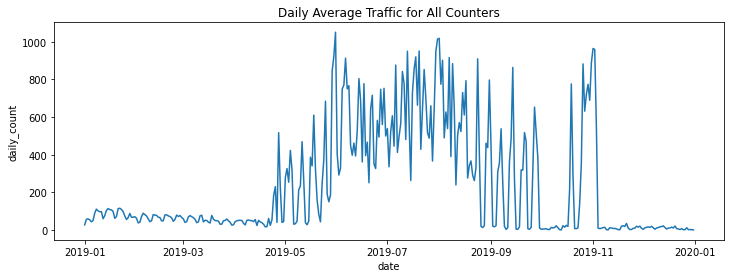

In [ ]:
daily_average = daily_count.groupby('date').mean()

plt.figure(figsize=(12,4))
sns.lineplot(x=daily_average.index, y=daily_average['daily_count'])
plt.title('Daily Average Traffic for All Counters')

Restrooms meet a significantly larger number of visitors in **summer**, **weekends in the beginning of September** and **holiday season**. Possible explanation are heated temparatue, which drives water consumption and thus restroom usages, school breaks, and holiday breaks. 

Additionally, demands slightly increase in weekends, compared to weekdays.

---

In [ ]:
# Rename columns for prospective join operations
daily_count.rename({"vru_id":'vru_id1', "date":'date1'}, axis=1, inplace=True)

# Join daily_count with vru_log
join_daily_count_vru = """
  SELECT *
  FROM daily_count DC JOIN vru_log V ON DC.vru_id1=V.vru_id AND DC.date1=V.date
"""

vru_log = ps.sqldf(join_daily_count_vru, locals())
# Drop join keys
vru_log.drop(['date1','vru_id1'], axis=1, inplace=True)

In [ ]:
vru_log.head(3)

,daily_count,vru_id,timestamp,counter_in,batterylevel,signal_quality,signal_strength,software_version,dcu_id,dcu_version,status,weekday,month,TimeofDay,date,hourly_entry_count
0,61,1930.0,2019-01-01 09:00:00.000000,334463,3240,255,82,42,134,9,0.0,1,1,9,2019-01-01,NaN
1,61,1930.0,2019-01-01 10:00:00.000000,334470,3240,255,82,42,134,9,0.0,1,1,10,2019-01-01,3.5
2,61,1930.0,2019-01-01 11:00:00.000000,334475,3240,255,88,42,134,9,0.0,1,1,11,2019-01-01,2.5


We then join *vru_log* with *locations* to gain insights into how locations, sites affect restroom usages.

In [ ]:
join_vru_loc_query = """
  WITH sl AS(
    SELECT CustomerId, SiteId, CountryCode, LocationId, LowUrgencyThreshold, 
           HighUrgencyThreshold, PeopleCounterId,locationDensity, NodeLevel
    FROM site_loc
  )
  SELECT *
  FROM sl JOIN vru_log VL ON sl.PeopleCounterId=VL.vru_id
"""

people_loc = ps.sqldf(join_vru_loc_query, locals())
people_loc.drop_duplicates(inplace=True)

In [ ]:
people_loc.SiteId.value_counts()

32    98469
23    58443
Name: SiteId, dtype: int64

Unfortunately, only sensors from *site32* and *site23* have been gathered. The people flow traffic data could only represent data from those two sites.

In [ ]:
location_daily = people_loc[['daily_count','LocationId','date','NodeLevel','locationDensity']].drop_duplicates()
location_daily.head(5)

,daily_count,LocationId,date,NodeLevel,locationDensity
0,8,233,2019-01-29,3,6
2,61,233,2019-01-01,3,6
10,167,233,2019-01-06,3,6
20,169,233,2019-01-05,3,6
34,173,233,2019-01-03,3,6


Moving foward to *sensors* table. In addition to finding locations needing more dispensers using traffic data, we also use **refillment frequency** to evaluate if dispensers' supply is adequate. **If a dispenser is refilled more frequent than normal pattern, it either implies a sensor malfunction, or a need for more cleaning product supplies.**

In [ ]:
dispensers.isna().sum()/len(dispensers.index)

DispenserId               0.000000
LocationId                0.000000
DispenserArticleNumber    0.000000
IsProvisioned             0.000000
CreatedAt                 0.000000
DispenserType             0.000000
NumberOfSensors           0.000000
ProductName               0.000000
RefillArticleNumber       0.158346
dtype: float64

Only column **RefillArticleNumber** has 15.8% missing values.

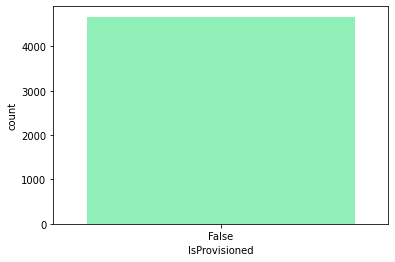

In [ ]:
sns.countplot(x=dispensers.IsProvisioned, palette=PALETTE)
plt.show()

All entries in *dispensers* has **isProvisioned** labeled False.

## Highlight 6: Dispenser per Location <a class="anchor" id="S2.6"></a>



In [ ]:
dispenser_per_location = dispensers.groupby("LocationId").DispenserId.count().reset_index(name='count').sort_values(['count'],ascending=False)
print("Average dispensers per location is {} ".format(dispenser_per_location['count'].sum()/len(dispenser_per_location.index)))

Average dispensers per location is 3.1640677966101696 


On average, each location has about 3 dispenser mounted for usage.

Text(0.5, 1.0, 'Number of Dispensers per Location Distribution')

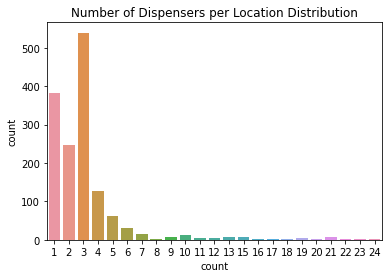

In [ ]:
sns.countplot(dispenser_per_location['count'])
plt.title('Number of Dispensers per Location Distribution')

Most locations have 1-4 sensors, with a small number of locations have more than 10 sensors. From this we could see that most location in our set are nomral size washroom or similar place that require small amount of dispensers.



***





## Highlight 7: Dispenser per Visit Ratio <a class="anchor" id="S2.7"></a>




In [ ]:
location_daily_mean = location_daily.groupby('LocationId').daily_count.mean().reset_index(name='avg_daily')
traffic_vs_dispenser = dispenser_per_location.merge(location_daily_mean, how='left', on='LocationId')

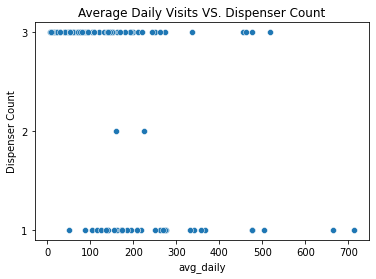

In [ ]:
sns.scatterplot( x='avg_daily', y='count',data=traffic_vs_dispenser)
plt.ylabel('Dispenser Count')
plt.yticks(np.arange(1,4, 1.0))
plt.title('Average Daily Visits VS. Dispenser Count')
plt.show()

Due to limits of given data, only locations with 1-3 dispensers have traffic data recorded in *vru_log*. However, visualization above indicates some locations, in the bottom-right corner of the scatter plot, welcome a averaged daily number of visitors greater than 600, yet only have 1 dispenser installed. 

This observation lays the prime focus of our subsequent analysis. To boost dispenser sales and thus in return generate revenue, our goal is to identifify restrooms experience heavy traffic, yet are only equipped with relatively insufficient number of dispensers. Locating these restrooms helps Tork elevate its product supply to meet the excessive demand. Tork's customers, in return, is rewarded with a reduced dispenser refill frequency, shortened cleaning hours and, ultimately, an energy-efficient and cleaner restroom environment.

### Outlier Detection: Find Insufficient Dispensers via Number of Visitors <a class="anchor" id="S2.7.1"></a>

In [ ]:
# Find ratio of number of dispensers over daily visitor count
traffic_vs_dispenser['log_dispenser_per_visit_ratio'] = np.log(traffic_vs_dispenser['count']/traffic_vs_dispenser.avg_daily)
traffic_vs_dispenser['dispenser_per_visit_ratio'] = traffic_vs_dispenser['count']/traffic_vs_dispenser.avg_daily

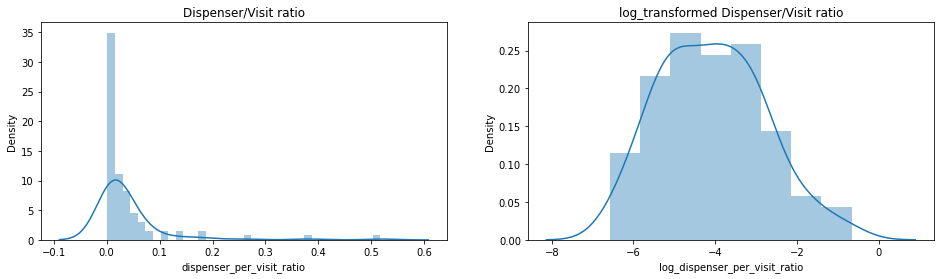

In [ ]:
_,axes = plt.subplots(1,2,figsize=(16,4))

sns.distplot(traffic_vs_dispenser.log_dispenser_per_visit_ratio, ax=axes[1])
axes[1].title.set_text("log_transformed Dispenser/Visit ratio")

sns.distplot(traffic_vs_dispenser.dispenser_per_visit_ratio, ax=axes[0])
axes[0].title.set_text("Dispenser/Visit ratio")

In [ ]:
Q1 = traffic_vs_dispenser.dispenser_per_visit_ratio.quantile(0.25)
Q3 = traffic_vs_dispenser.dispenser_per_visit_ratio.quantile(0.75)
IQR = Q3 - Q1 

traffic_vs_dispenser[(traffic_vs_dispenser['dispenser_per_visit_ratio']<(Q1-1.5*IQR))|(traffic_vs_dispenser['dispenser_per_visit_ratio']>(Q3+1.5*IQR))]

,LocationId,count,avg_daily,log_dispenser_per_visit_ratio,dispenser_per_visit_ratio
651,421,3,16.520000,-1.705959,0.181598
662,395,3,29.080000,-2.271438,0.103164
666,422,3,16.208333,-1.686913,0.185090
673,433,3,20.889764,-1.940647,0.143611
674,438,3,22.125000,-1.998096,0.135593
678,1202,3,5.802419,-0.659663,0.517026
679,1201,3,11.425101,-1.337201,0.262580
773,253,3,28.840000,-2.263151,0.104022
844,719,3,7.888889,-0.966843,0.380282


We pinpointed restrooms with insufficient number of dispensers using IQR outlier detection method. We started by defining a new metric to evaluate dispenser sufficiency per restroom. 

<center>$\text{Dispenser per Visit Ratio} = \frac{Number of Dispensers}{Average Daily Visitor Count}$</center>

A larger ratio implies a higher likelihood the number of dispesners meet the usage needs. 

We then calculated the difference between 25 and 75 percentils of population ratio, filtered locations 1.5 times this difference below the 25 percentile. This methology gives us a list of restrooms in need of more dispensers. We label these locations 1 as **NotEnoughDispenser**, 0 otherwise.

In [ ]:
def label_enough_dispenser(row):
  if row<Q1-1.5*IQR: 
    return 1
  else:
    return 0

traffic_vs_dispenser['NotEnoughDispenser'] = traffic_vs_dispenser.dispenser_per_visit_ratio.apply(func=label_enough_dispenser)

Our next step is to find restrooms requiring more dispenrs using *scu_log*.  *scu_log* documents if dispensers' level of full grades. 

Multiple scenarios lead to a dispenser drained up frequently: heavy traffic, visitors' immoderate consumption, malfunctioned sensors. We will be illustrating these scenarios accordingly.



---



In [ ]:
scu_log.head(3)

,scu_id,timestamp,manufacture_year,sensor1,sensor2,gen_counter,batterylevel,signal_quality,signal_strength,software_version,DispenserId,intervall,empty_level,full_level,hysteresis,linked_scu_id,linked_scu_manufacture_year,link_pos,dispenser_type,scuStatus
0,9617,2019-01-01 00:00:01.0000000,10,1347,64,0,2970,255,67,6,2892,30,700,250,50,0,0,0,T2TwinB,Green
1,3377,2019-01-01 00:00:11.0000000,10,7,8,0,3000,255,74,5,2893,30,150,400,400,3376,10,1,H2,Green
2,3773,2019-01-01 00:00:41.0000000,10,758,696,0,2980,255,82,5,2816,30,150,400,400,3767,10,1,H2,Green


Dispensers' level of full is evaluated under column **scuStatus**, with class 'Green' as full, 'yellow' as moderate, and 'red' as drained. We started with counting, for each dispenser, the number of times each types of signal is generated daily.

In [ ]:
# Transform timestamp from type string to type datetime
scu_log_new = pd.get_dummies(scu_log, columns = ["scuStatus"])
scu_log_new["timestamp"] = pd.to_datetime(scu_log_new["timestamp"])

# Extract date
scu_log_new["date"] = scu_log_new["timestamp"].dt.date

In [ ]:
scu_log_temp = scu_log_new.groupby(["DispenserId", "date"]).agg({"scuStatus_Red": sum, "scuStatus_Green": sum, "scuStatus_Yellow": sum, "timestamp": "count"})
scu_log_temp

scuStatus_Red  ...  timestamp
DispenserId date                       ...           
287         2019-01-01              1  ...          4
            2019-01-02              0  ...          3
            2019-01-03              0  ...          6
            2019-01-04              0  ...          2
            2019-01-05              0  ...          5
...                               ...  ...        ...
52247       2019-06-05              0  ...          6
            2019-06-06              0  ...          3
            2019-06-07              0  ...          3
            2019-06-08              0  ...          3
            2019-06-09              0  ...          3

[610545 rows x 4 columns]

In [ ]:
print(scu_log_temp.describe(percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

       scuStatus_Red  scuStatus_Green  scuStatus_Yellow      timestamp
count  610545.000000    610545.000000     610545.000000  610545.000000
mean        0.373928         3.232677          0.102978       3.871644
std         1.469326         7.642086          0.862567       8.019548
min         0.000000         0.000000          0.000000       1.000000
25%         0.000000         1.000000          0.000000       1.000000
50%         0.000000         2.000000          0.000000       2.000000
75%         0.000000         3.000000          0.000000       4.000000
90%         1.000000         6.000000          0.000000       8.000000
95%         2.000000        10.000000          0.000000      13.000000
99%         5.000000        31.000000          2.000000      34.000000
max       152.000000       360.000000         60.000000     361.000000


Notice that status **Green** is generated most frequently, on average 3 times daily,  whereas **Red** and **Yellow** are generated about 1 times per day. However, signal **Red** does have outliers above 90 percentiles that are activated more than 2 times per day, which implies unusually frequent refillment needs.

We thus retrieved entries with 'red' under **scuStatus** to find a sensor's refill interval.

## Highlight 8: Find Dispensers' Refillment Interval <a class="anchor" id="S2.8"></a>
Since we already know the dispenser refill signal will turn red if a refill is needed, we could find the average interval for those dispensers, which could help us to gain an insight on how quick does dispensers are refilled by cleaning staff after a signal is sent.

In [ ]:
red_scu = scu_log[scu_log['scuStatus']=='Red']
red_scu.sort_values(['scu_id','timestamp'], inplace=True)

red_scu['timestamp'] = pd.to_datetime(red_scu.timestamp)
red_scu['red_interval'] = red_scu.timestamp.diff()

# Adjust boundaries
mask = red_scu.scu_id != red_scu.scu_id.shift(1)
red_scu['red_interval'][mask] = np.nan

# Normalize unit to minute
red_scu.red_interval = red_scu.red_interval.dt.seconds/60.0

In [ ]:
# Average interval between red signals per location
avg_red = red_scu.groupby(['scu_id','DispenserId']).red_interval.mean().reset_index(name = 'avg_interval').sort_values('avg_interval')

### Data Integrity: Duplicated Signals <a class="anchor" id="S2.8.1"></a>

We notice one problem with given data is that a signal may be sent out repeatively at the same timestamp. In other words, when a dispenser is low on product and need a refill, it will constantly sending multiple red signal for a refill request, which means several request are regarding same dispenser at the same time. For example:

In [ ]:
red_scu[red_scu['scu_id']==38603][['timestamp', 'scuStatus', 'red_interval']]

,timestamp,scuStatus,red_interval
354737,2019-01-28 17:02:17,Red,NaN
354738,2019-01-28 17:02:17,Red,0.0
354739,2019-01-28 17:02:17,Red,0.0


In [ ]:
# Find number of times each sensor repeatively send 'red' within 1 minute
red_scu[red_scu.red_interval<=1].groupby(['scu_id','timestamp']).count()['red_interval'].reset_index(name='count_duplicate').sort_values('count_duplicate', ascending=False)

,scu_id,timestamp,count_duplicate
29566,13201,2019-02-03 21:40:13,6
29573,13201,2019-02-11 10:04:07,6
56491,43858,2019-01-09 23:12:37,6
51665,39057,2019-03-15 18:07:21,6
51666,39057,2019-03-16 00:19:56,6
...,...,...,...
20672,12966,2019-01-26 00:16:38,1
20673,12966,2019-01-27 00:16:37,1
20674,12966,2019-01-27 06:28:37,1
20675,12966,2019-01-28 06:28:35,1


---

To remove these duplicated signals, we set threshold for 2 distinct signals to be 1 hour. Only signals that are separated into 1 hour above are consider two different refill request.

In [ ]:
red_scu_distinct = red_scu[red_scu.red_interval>60].drop_duplicates()

In [ ]:
red_scu_distinct.head(3)

,scu_id,timestamp,manufacture_year,sensor1,sensor2,gen_counter,batterylevel,signal_quality,signal_strength,software_version,DispenserId,intervall,empty_level,full_level,hysteresis,linked_scu_id,linked_scu_manufacture_year,link_pos,dispenser_type,scuStatus,red_interval
1625377,2,2019-04-29 08:08:18,11,531,531,0,3520,255,61,23,8960,30,330,330,50,0,0,0,B1,Red,1097.000000
1628039,2,2019-04-29 11:20:18,11,660,660,0,3510,255,58,23,8960,30,330,330,50,0,0,0,B1,Red,104.000000
1644319,2,2019-04-30 14:12:20,11,660,660,0,3510,255,58,23,8960,30,330,330,50,0,0,0,B1,Red,80.033333


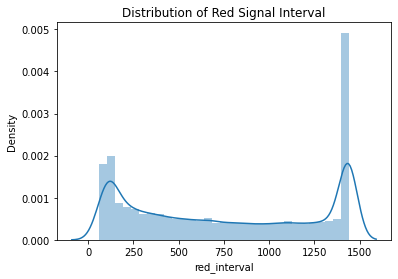

                  timestamp  red_interval  scu_id
608312  2019-02-17 00:31:27   1439.983333   28054
1445624 2019-04-15 22:48:19   1439.983333    3495
1260490 2019-04-03 19:16:21   1439.983333    3495
1275747 2019-04-04 19:16:20   1439.983333    3495
1340200 2019-04-09 19:16:20   1439.983333    3495
...                     ...           ...     ...
1423031 2019-04-14 15:20:45     60.016667   19438
2054517 2019-05-24 17:00:41     60.016667   13173
2089015 2019-05-26 13:07:20     60.016667   13173
813800  2019-03-03 10:43:35     60.016667   34495
1757060 2019-05-08 09:26:26     60.016667   43763

[109218 rows x 3 columns]


In [ ]:
sns.distplot(red_scu_distinct.red_interval)
plt.title('Distribution of Red Signal Interval')
plt.show()

print(red_scu_distinct.sort_values('red_interval', ascending=False)[['timestamp','red_interval','scu_id']])

This distribution plot has 2 bumps. A large number of red signals are sent within the period of 2 hours or around 1 day. Which indicates an approximate 2-hour and 24-hour average depletion window for most dispnesers recorded. \\

Statistically, most dispenser would need daily refill routine while some of them might need a higher maintenance frequency to keep them providing service.

We then join *scu_log* with traffic count per location.

In [ ]:
query_scu_location = """
  WITH loc AS(
    SELECT DispenserId, LocationId, Quality
    FROM dispensers D LEFT JOIN refillassotment R ON D.DispenserType=R.DispenserType
  )
  SELECT 
    RS.DispenserId, L.LocationId, avg_interval,
     SiteId, Quality, locationDensity, NodeLevel
  FROM loc L LEFT JOIN avg_red RS  ON L.DispenserId=RS.DispenserId
       JOIN people_loc PL ON PL.LocationId = L.LocationId
"""

query_daily_scu = """
  SELECT DispenserId, TD.LocationId, avg_interval,
  avg_daily, SiteId, Quality, NotEnoughDispenser, count, locationDensity, Nodelevel
  FROM traffic_vs_dispenser TD LEFT JOIN scu_location SL ON TD.LocationId=SL.locationId
"""

scu_location = ps.sqldf(query_scu_location, locals())
scu_traffic = ps.sqldf(query_daily_scu, locals())

scu_traffic.drop_duplicates(inplace=True)

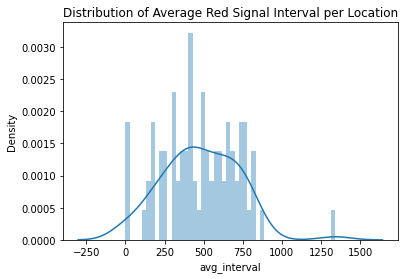

In [ ]:
sns.distplot(scu_traffic.groupby('LocationId').avg_interval.mean(), bins=50)
plt.title('Distribution of Average Red Signal Interval per Location')
plt.show()

Since the above graph representing the average interval in of dispenser refill signal of each location, the average value is easily influenced by the extreme value like the 24-hour depletion cycle we discussed in the previous graph. \\
Once thing worth noting is that, not all locations with a *vru_log* have *scu_log* recorded. Some data was lost after the join operation.

### Outlier Detection: Find Insufficient Dispensers via Refillment Interval <a class="anchor" id="S2.8.2"></a>

In order to find locations with insufficient dispenser supply, we are interested in locations in the right tail of the distribution plot above.

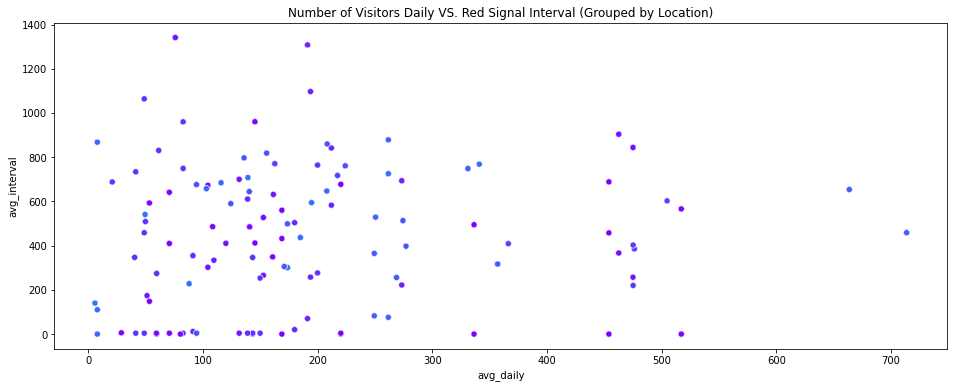

In [ ]:
scu_traffic['LocationId'] = scu_traffic['LocationId'] .astype('category')

scu_traffic_temp = scu_traffic.dropna(subset=['avg_interval','avg_daily'], axis=0)
plt.figure(figsize=(16,6))
sns.scatterplot(x='avg_daily', y='avg_interval', data=scu_traffic_temp, hue='LocationId', c=5, legend=False, palette='rainbow')
plt.title("Number of Visitors Daily VS. Red Signal Interval (Grouped by Location)")
plt.show()

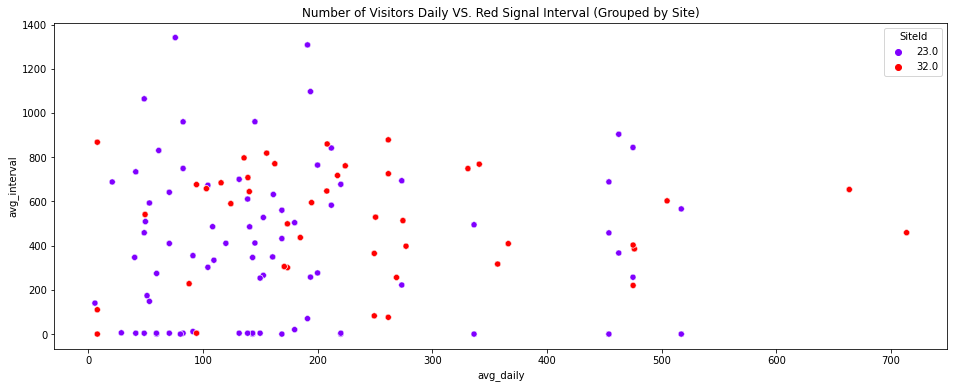

In [ ]:
plt.figure(figsize=(16,6))
sns.scatterplot(x='avg_daily', y='avg_interval', hue='SiteId', data=scu_traffic, c=5, palette=PALETTE)
plt.title("Number of Visitors Daily VS. Red Signal Interval (Grouped by Site)")
plt.show()

We define a new metric to analyze if dispensers are suffice:

<center>$\frac{Average Daily Visitor}{Average Refillment Interval}$</center>

A larger value implies high traffic, high refillment frequency, or both, indicating urgent for more dispensers to supply the higher need in those location for providing services.

Again, we used interquantile range to find locations with such needs.

In [ ]:
scu_traffic['Visitor_Interval_ratio'] = scu_traffic.avg_daily/scu_traffic.avg_interval
Q1 = scu_traffic.Visitor_Interval_ratio.quantile(0.25)
Q3 = scu_traffic.Visitor_Interval_ratio.quantile(0.75)
IQR = Q3-Q1 

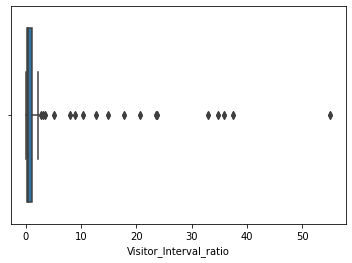

In [ ]:
sns.boxplot(scu_traffic.Visitor_Interval_ratio)

In [ ]:
def frequent_dispenser(row):
  if row>Q3+1.5*IQR:
    return 1 
  return 0 
scu_traffic['FrequentRefill'] = scu_traffic.Visitor_Interval_ratio.apply(frequent_dispenser)

In [ ]:
scu_traffic.FrequentRefill.value_counts()

0    1852
1      68
Name: FrequentRefill, dtype: int64

---

## Highlight 9: Impact of Product Quality on Refillment Frequency <a class="anchor" id="S2.9"></a>

We also noticed that different spensers across the data are providing different quality of toilet paper. Therefore, we also dug into the relationship between product quality and the refill interval of certain dispenser.

In [ ]:
scu_location_new = scu_location.drop_duplicates()

In [ ]:
# Find composition of products of different quality level per location
scu_location_2 = scu_location_new.groupby(["LocationId","Quality"])["SiteId"].count().dropna().reset_index().rename(columns= {"SiteId": "count"}).merge(scu_location_new.groupby(["LocationId"])["SiteId"].count().dropna().reset_index().rename(columns= {"SiteId": "totalCount"}), on = "LocationId")
scu_location_2["ratio"] = scu_location_2["count"]/ scu_location_2["totalCount"]
scu_location_2

,LocationId,Quality,count,totalCount,ratio
0,233,Advanced,4,11,0.363636
1,233,Premium,4,11,0.363636
2,233,Universal,3,11,0.272727
3,234,Advanced,5,13,0.384615
4,234,Premium,5,13,0.384615
...,...,...,...,...,...
276,1201,Premium,1,3,0.333333
277,1201,Universal,1,3,0.333333
278,1202,Advanced,2,6,0.333333
279,1202,Premium,2,6,0.333333


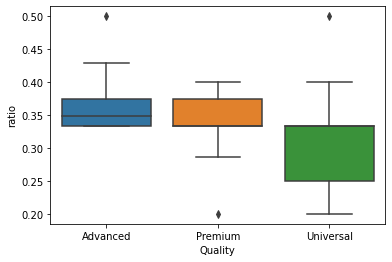

In [ ]:
sns.boxplot(x='Quality',y='ratio', data=scu_location_2)
plt.show()

Most existing clients adopt products of mixed qualities. The medium proportions of advanced and premium quality is slightly higher than universal quality.

Then a question arise, is it possible to convince users replace more **Universal** level products with **Premium** or **Advanced** level products?

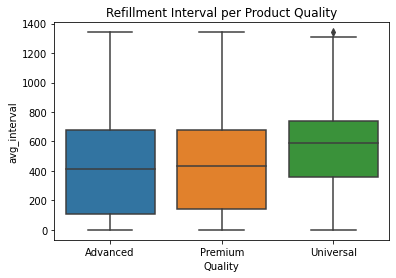

In [ ]:
sns.boxplot(x='Quality',y='avg_interval', data=scu_location_new)
plt.title('Refillment Interval per Product Quality')
plt.show()

In [ ]:
scu_location_new.groupby(["Quality"])["SiteId"].count().dropna().reset_index().rename({"SiteId": "count"})

,Quality,SiteId
0,Advanced,198
1,Premium,191
2,Universal,150


Visual above suggests **Premium** and **Advanced** quality have the least median refillment interval out of all qualities. Possible theory behind this is that higher quality product might need less quantity to fulfill need of a certain user and provide a higher satisfaction washroom user experience.

We thus propose the marketing strategy to emphasize on **Premium** and **Advanced** products to customers demanding reduced cleaning time. As advanced and premium quality products are priced higher, Tork can, in return, receives a boost in total retail revenue.

# Modeling <a class="anchor" id="S3"></a>

**1. Problem Formulation**

  In the following seciont, we train supervised machine learning models to answer 2 core questions:
  1. Regression: For incoming users, what is the optimal number of dispensers per location?
  2. Binary Classification: For existing customers, is the current number of dispensers per location sufficient? 

**2. Analysis Rewind**

 In the previous section, via visualiztion and statistical analysis, we have gained some insights out of data:
  1. **LocationDensity** represents the number of locations under the same **ParentNode**.
  2. We calculated daily, hourly **visitor_count** per location.
  3. We calculated the interium between 2 consecutive "red_signal" for each SCU sensor.
  4. Clients adopt a mixed composition of all product types. **Premium** and **Advanced** product has a lower refillment frequency.

**3. Modeling Methodology**

  We chose **Random Forest** to perform both Regression and Classification analysis, for following reasons:
  
  1. Random Forest avoids overfitting by synthesizing the output of a bag of decision trees, each trained on only a subset of features. 
  2. Random Forest performs well on imbalanced dataset. As we only have a small number of locations with insufficient dispensers, this property perfectly meets our needs.
  3. Despite some deep learning methods may achieve higher prediction accuracy, Random Forest stands out with its interpretability, generating a quantified feature importance. For a business analytical problem, Random Forest's interpretability helps us unveil which factor has the highest impact on dispenser optimization problem. 


## Prepare Data <a class="anchor" id="S3.1"></a>

In [ ]:
# Join site information with traffic data
sites_copy = sites[['CustomerId','CountryCode','CreatedAt','UpdatedAt','SubscriptionRate','SubscriptionStart','SiteId']]
scu_traffic_site = scu_traffic.merge(sites_copy.rename({'SiteId':'SiteId1'}, axis=1),how='inner', left_on='SiteId', right_on='SiteId1').drop('SiteId1', axis='columns')

In [ ]:
scu_traffic_site.isna().sum()/len(scu_traffic_site.index)

DispenserId               0.274583
LocationId                0.000000
avg_interval              0.389610
avg_daily                 0.000000
SiteId                    0.000000
Quality                   0.000000
NotEnoughDispenser        0.000000
count                     0.000000
locationDensity           0.000000
NodeLevel                 0.000000
Visitor_Interval_ratio    0.389610
FrequentRefill            0.000000
CustomerId                0.000000
CountryCode               0.000000
CreatedAt                 0.000000
UpdatedAt                 0.000000
SubscriptionRate          0.000000
SubscriptionStart         0.000000
dtype: float64

Because not all locations with visitor count from *vru_log* have refillment sensor records from *scu_log*, we thus add 1 additional column **scu_recorded**, 1 as have sensor records, 0 otherwise.

In [ ]:
scu_traffic_site['scu_recorded'] = scu_traffic_site.avg_interval.isna().apply(lambda x: 1 if x==0 else 0)
scu_traffic_site.scu_recorded.value_counts()

1    329
0    210
Name: scu_recorded, dtype: int64

We substitued missing values under **avg_interval** and **visitor_interval_ratio** with -1, a value non-existant in available data.

In [ ]:
scu_traffic_site.avg_interval.fillna(-1, inplace=True)
scu_traffic_site.Visitor_Interval_ratio.fillna(-1, inplace=True)

scu_traffic_site.avg_interval = scu_traffic_site.avg_interval.replace([np.inf, -np.inf], -1)
scu_traffic_site.Visitor_Interval_ratio = scu_traffic_site.Visitor_Interval_ratio.replace([np.inf, -np.inf], -1)

In [ ]:
scu_traffic_site.isna().sum()/len(scu_traffic.index)

DispenserId               0.077083
LocationId                0.000000
avg_interval              0.000000
avg_daily                 0.000000
SiteId                    0.000000
Quality                   0.000000
NotEnoughDispenser        0.000000
count                     0.000000
locationDensity           0.000000
NodeLevel                 0.000000
Visitor_Interval_ratio    0.000000
FrequentRefill            0.000000
CustomerId                0.000000
CountryCode               0.000000
CreatedAt                 0.000000
UpdatedAt                 0.000000
SubscriptionRate          0.000000
SubscriptionStart         0.000000
scu_recorded              0.000000
dtype: float64

We drop all features that uniquely identify a site, a location or a sensor.

In [ ]:
scu_traffic_site.drop(['DispenserId','LocationId','SiteId','CustomerId','SubscriptionRate'], axis=1, inplace=True)

We transformed all timestamp to days away from the basedate '2020-01-01'. As all entries are collected in the year of 2019, all time relevant data are thus positive.

In [ ]:
basedate = pd.Timestamp('2020-01-01 12:00:00', tz='UTC')
scu_traffic_site[['CreatedAt','UpdatedAt','SubscriptionStart']] = scu_traffic_site[['CreatedAt','UpdatedAt','SubscriptionStart']].apply(pd.to_datetime)

scu_traffic_site.SubscriptionStart = pd.to_datetime(scu_traffic_site.SubscriptionStart)
scu_traffic_site.SubscriptionStart = (basedate-scu_traffic_site.SubscriptionStart).dt.days.astype(int)
scu_traffic_site.DaysCreated = (basedate-scu_traffic_site.CreatedAt).dt.days.astype(int)
scu_traffic_site.DaysUpdated = (basedate-scu_traffic_site.UpdatedAt).dt.days.astype(int)

scu_traffic_site.drop(['CreatedAt','UpdatedAt'], axis=1, inplace=True)

In [ ]:
# Transform categorical features to dummies
scu_traffic_site[['Quality','CountryCode']] = scu_traffic_site[['Quality','CountryCode']].astype("category")
scu_traffic_site = pd.get_dummies(scu_traffic_site, columns=['Quality','CountryCode'])

Below is a list of variables we used:

|     Name    	|     Explanation    	|     Comment    	|
|-	|-	|-	|
| avg_interval | Average refillment request of all dispensers | |
| avg_daily| Average number of visitors| |
| Quality_... | Dummy variables, product quality level | Premium, Advance, Universal |
| locationDensity | Number of child-locations under the parent structure | |
| NodeLevel | How deep the structure the location is | |
| Visitor_Interval_Ratio | Number of visitors / avg_daily| |
|Country_code_... | Dummy variables, sites' country code | |
|DaysCreated | Days a subscription has been created since 2020-01-01 | |
|DaysUpdated | Days a subscription has been updated since 2020-01-01 | |
|SubscriptionStart | Days a subscription has started since 2020-01-01 | |
|scu_recorded| number of sensors | |
| count | Total number of dispensers | Dependent variable for **Regression**|
| NotEnoughDispenser | If number of dispensers are sufficient | 1 insufficient, 0 sufficient|
| FrequentRefill | If refillment needs are too frequent | 1 frequent, 0 normal |
| NotEnoughDispenser & FrequentRefill | 1 if **either** NotEnoughDispenser **or** FrequentRefill, 0 otherwise | Dependent variable for **Classification**|





In [ ]:
# Visualization Helper Function
def plot_feature_importance(importance,names,model_type):

  feature_import = np.array(importance)
  feature_names = np.array(names)
  data={'feature_names':feature_names,'feature_importance':feature_import}
  df = pd.DataFrame(data)
  df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  plt.figure(figsize=(4,8))
  sns.barplot(x=df['feature_importance'], y=df['feature_names'])
  plt.title(model_type + 'Feature Importance')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

def plot_confusion_matrix(cm):

  title = "Random Forest Classifier"
  plt.figure(figsize=(6.4, 4.8))
  sns.heatmap(cm, annot=True, cmap='viridis')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()
  
def plot_precision_recall_curve(y_test, lr_recall, lr_precision):

  no_skill = len(y_test[y_test==1]) / len(y_test)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  plt.plot(lr_recall, lr_precision, marker='.', label='RF_Classifier')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

## Regression <a class="anchor" id="S3.2"></a>
1. Output: 

  Random Forest Regressor predicts the number of optimal dispensers per location.
2. Data:

  The model is trained only on locations with a sufficient number of dispensers, that is, both **FrequentRefill** and **NotEnoughDispenser** are labled as false. This group of data is later names as **scu_traffic_site_enough**.

  The model is evaluated on the testing set(30%) from **scu_traffic_site_enough**.

  The model is later tested on **scu_traffi_site_not_enough**, suggesting how many additional dispensers these location should install.

Only use locations with sufficient dispensers **and** infrequent refillment needs.

In [ ]:
scu_traffic_site_enough = scu_traffic_site[(scu_traffic_site['FrequentRefill']!=1) &(scu_traffic_site['NotEnoughDispenser']!=1)]
scu_traffic_site_not_enough = scu_traffic_site[(scu_traffic_site['FrequentRefill']==1) |(scu_traffic_site['NotEnoughDispenser']==1)]

In [ ]:
y = scu_traffic_site_enough['count']
X = scu_traffic_site_enough.drop('count', axis=1)

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

print("X_train shape is.{}".format(X_train.shape))
print("y_train shape is.{}".format(y_train.shape))
print("X_test shape is.{}".format(X_test.shape))
print("y_test shape is.{}".format(y_test.shape))

X_train shape is.(329, 14)
y_train shape is.(329,)
X_test shape is.(142, 14)
y_test shape is.(142,)


In [ ]:
RF_regression = RandomForestRegressor()
RF_regression.fit(X_train, y_train)
predicted = RF_regression.predict(X_test)
RF_regression.score(X_test, y_test)

0.9654586872051069

In [ ]:
metrics.mean_squared_error(y_test, predicted)

0.02468802816901409

[0.5723036753440258, 0.17885755760234442, 0.15239077361851158, 0.07499962675505069, 0.007401443538562883, 0.00709949597053822, 0.0032556442189034304, 0.0025819790207410537, 0.001109803931321972, 0.0, 0.0, 0.0, 0.0, 0.0]


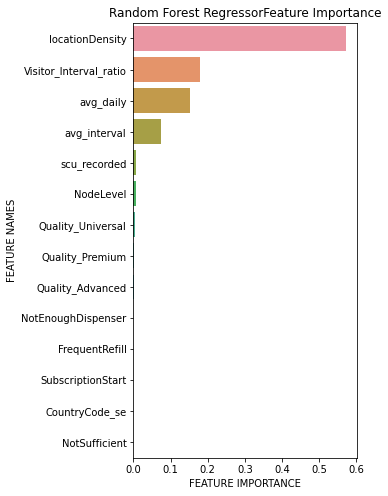

In [ ]:
plot_feature_importance(RF_regression.feature_importances_, X_train.columns,'Random Forest Regressor')
print(sorted(RF_regression.feature_importances_, reverse=True))

#### Model Tuning <a class="anchor" id="S3.2.1"></a>
Tune model via randomized cross-validated grid search.

In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [10, 20, 50, 100]
max_depth = [3, 5, 10]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_regressor_tuned = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
rf_regressor_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   23.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

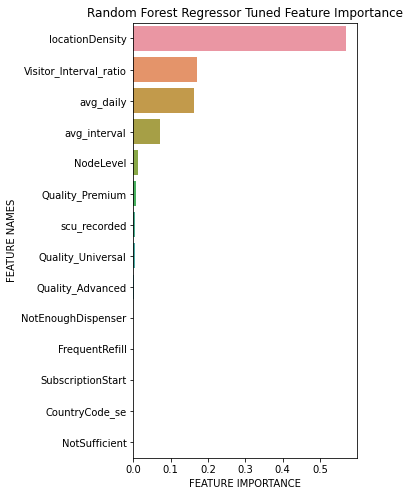

In [ ]:
plot_feature_importance(rf_regressor_tuned.best_estimator_.feature_importances_, X_train.columns, 'Random Forest Regressor Tuned ')

In [ ]:
import math
predicted = rf_regressor_tuned.predict(X_test)
print("Random Forest score {}".format(rf_regressor_tuned.score(X_test, y_test)))
print("Random Forest Accuracy score {}".format(metrics.mean_squared_error(y_test, (predicted))))

Random Forest score 0.9605187280950682
Random Forest Accuracy score 0.028218810290313312


After tuning, Random Forest achieved a $R^2$ 0.960 and testing MSE 0.028.

We then evaluated this model on locations with insufficient number of dispensers.

In [ ]:
predicted = RF_regression.predict(scu_traffic_site_not_enough.drop(['count'],axis=1))
result = pd.DataFrame({'predicted': predicted, 'value':scu_traffic_site_not_enough['count']})
result['difference'] = abs(result.predicted-result.value)

In [ ]:
print("Average number of additional dispensers to be installed {}".format(result.difference.values.mean()))

Average number of additional dispensers to be installed 0.20102941176470587


#### Result and Interpretation <a class="anchor" id="S3.2.2"></a>

1. After tuning, Random Forest achieved a $R^2$ 0.960 and testing MSE 0.028.


2. Despite that the evaluation metrics seem pleasing, this does not suggest we have achieved a perfect model, which may limit the model's generalizability. The training set only has 342 entries. However, if more data were given, following the same data processing steps and modeling techniques, this model can provide liable insights on the number of dispensers to be installed.

3. Feature Importance plot suggests, **site capacity, refillment frequency, daily number of visitors** are the top 3 factors to be evaluated when estimating the number of dispensers.

3. Testing the model on locations with inadequate number of dispensers, the final result suggests, on average, these locations need additional 0.2 dispensers. That is, 1 additional dispenser is needed for every 5 locations.

## Classification
1. Output: 

  If a location has sufficient number of dispensers. 1 for insufficient, 0 otherwise
2. Data:

  The model is trained on the entire dataset. 
  
  If an entry has either **FrequentRefill** and **NotEnoughDispenser** labled as 1, the entry is labeled as 1. The output lable is stored within **NotSufficient**.

In [ ]:
# Labeling Data
scu_traffic_site['NotSufficient'] = scu_traffic_site.NotEnoughDispenser|scu_traffic_site.FrequentRefill

X = scu_traffic_site.drop(['NotSufficient', 'NotEnoughDispenser', 'FrequentRefill', 'Visitor_Interval_ratio'],axis=1)
y = scu_traffic_site.NotSufficient

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
print("X_train shape is.{}".format(X_train.shape))
print("y_train shape is.{}".format(y_train.shape))
print("X_test shape is.{}".format(X_test.shape))
print("y_test shape is.{}".format(y_test.shape))

X_train shape is.(377, 11)
y_train shape is.(377,)
X_test shape is.(162, 11)
y_test shape is.(162,)


In [ ]:
# Train RandomForestClassifier with default parameters
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train, y_train)
predicted = RF_classifier.predict(X_test)
RF_classifier.score(X_test, y_test)

1.0

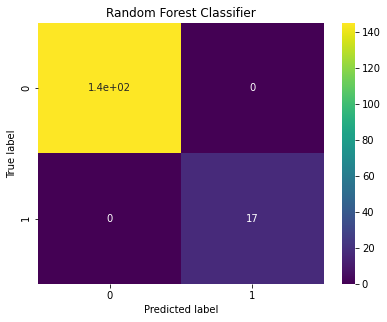

In [ ]:
cm = metrics.confusion_matrix(y_test, predicted)

plot_confusion_matrix(cm)

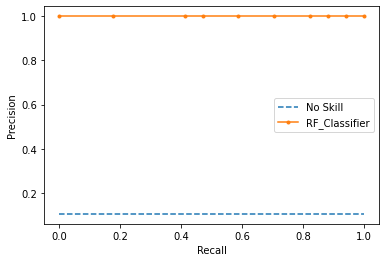

In [ ]:
# Calculate precision and recall for each threshold
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, RF_classifier.predict_proba(X_test)[:,1])

plot_precision_recall_curve(y_test, lr_recall, lr_precision)

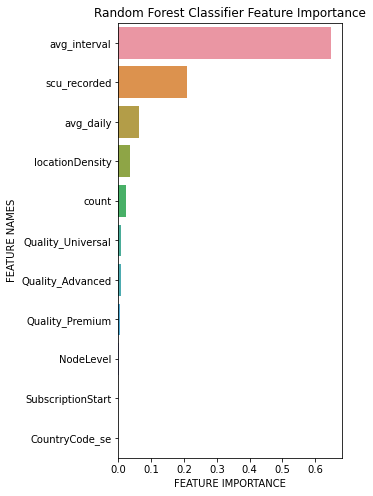

In [ ]:
plot_feature_importance(RF_classifier.feature_importances_, X_train.columns,'Random Forest Classifier ')

#### Result and Interpretation <a class="anchor" id="S3.3"></a>

1. We achieved a Random Forest Classifier with 0 False Positive and 0 False Negative, resulting in 100% accuracy and 100% F-1 score. 

2. As the dataset is highly imbalanced, we further evaluated the model using prediction-recall curve, which still outputs a 1 AUC, implying perfect classification.

3. Again, despite the evaluation metrics seem pleasing, this model is trained on a limited amount of data. Model generalibility can be improved if more data were given.

4. Feature Importance plot suggests, **daily number of visitors, refillment frequency and the number of SCU sensors** are the top 3 factors to be evaluated when estimating the number of dispensers.


# Limitation <a class="anchor" id="S6"></a>

Upon completing our model implementation and interpretation, we found several points across our board that limit the model performance. This limitation might come from the current data set, but this also gives us insight into where we can focus in our next step to improve our analysis.

First of all, we have a small size data set about people flow traffic data from sensors across all sites. The size mainly decreases the generality of our model in applying to more sites. If more people flow data and dispenser information are collected, we can avoid overfitting and make our model more versatile to all future clients.

Secondly, our site focuses on the relationship between refill frequency, dispenser density, and people flow of each site and location. If we could have access to more data, we would able to build a model more comprehensively. For example, if each site's business type is provided, we could have a sense of users' expectation, seasonal trend, age span of users, etc. All those information will help us predict the need and allocation of dispensers in those sites by providing the best services and least mandatory maintenance in those locations.

Thirdly, we could have more detailed information for higher accuracy and model robustness concerning the dispenser. Suppose we could get an understanding of the dispenser's existing floor. In that case, location, restroom type, and model will produce a more reliable accuracy in both the regression and classification model to deliver results to Tork's clients in optimizing and arranging cleaning staff.

We met all those limitations during our process, but it undoubtedly strengthens our belief in our model could help Tork's provide a better plan for clients and attract more business interest from the market.

# Conclusions <a class="anchor" id="S4"></a>

From our model, our goal is to help Tork boost bottom-line revenue by finding potential upsell from current clients and adaptively generating optimal plans for new clients. \\

We use a classification method for the current customer, trained on traffic flow data, dispenser data, to generate a supervised classification model that predicts if current dispenser allocation is adequate. This method will save customer cleaning costs and maintain a higher standard in the restroom environment. \\

For new clients, we use the existing restroom (dispenser) location data and traffic data to generate a supervised Regression model that predicts the optimal number of dispensers that can provide efficient services in those sites/locations. This approach can help the potential client estimate the cost saved using Tork's intelligent cleaning system services. \\

Both two sub-scenario can be improved if more detailed business data are provided, like the business type of sites, age span of users, seasonal weather, and activities in those sites. More features and data will enhance the robustness of classification and regression models and improve the accuracy in delivering reliable plans for Tork's customers. \\

From both scenarios mentioned above, our models could boost sales, increase Tork revenue, and subsequently promote subscriptions from current customers and future customers. 

# Next Steps <a class="anchor" id="S5"></a>

One problem with the data is that our criteria for labeling if a location has enough dispensers do not lead to a low number of minor classes, implying an imbalanced dataset. If given more time, to boost model robustness, a re-sampling of the class samples may be adopted. 

Secondly, we can establish more detailed criteria to classify dispenser sufficiency if more qualitative data, such as users' feedback and business type, were given. 

Besides, alternative modeling algorithms, such as XGBoost, Long-Short Term Memory for handling time series data (in this case, the refill signal and people flow counter), may produce a more accurate result than Random Forest. 

Finally, gaining more information data about the site and its business type will also improve the model performance and generate a more comprehensive analytical insight. A potential solution to enhance prediction accuracy is to train independent models based on a site's business type.